In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motorica-skillfactory-internship-test-2024-07/sample_submission.csv
/kaggle/input/motorica-skillfactory-internship-test-2024-07/y_train.csv
/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_test.npy
/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy


In [12]:
X_train = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_train.npy')
X_test = np.load('/kaggle/input/motorica-skillfactory-internship-test-2024-07/X_test.npy')

y_train = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/y_train.csv')
y_test = pd.read_csv('/kaggle/input/motorica-skillfactory-internship-test-2024-07/sample_submission.csv')
# y_test = pd.read_csv('./sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import RandomizedSearchCV

## Представление целевой переменной
### Kaggle-удобный вид

In [14]:
print(y_train.shape)
y_train

(32300, 2)


sample-timestep  class
0                 0-0      0
1                 0-1      0
2                 0-2      0
3                 0-3      0
4                 0-4      0
...               ...    ...
32295          322-95      4
32296          322-96      4
32297          322-97      4
32298          322-98      4
32299          322-99      4

[32300 rows x 2 columns]

<Axes: xlabel='class', ylabel='count'>

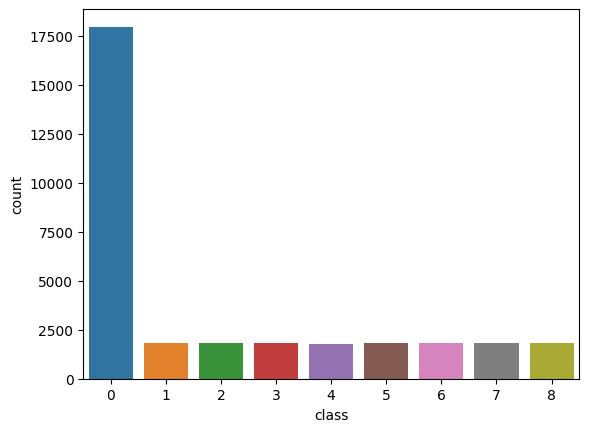

In [15]:
sns.countplot(data=y_train, x='class') #смотрим на сбалансированность классов

### Исходный вид

In [16]:
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)
y_train

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

In [17]:
#приведем массивы в двухмерный вид для построения модели
X_train = X_train.reshape(32300,40)
y_train = y_train.reshape(32300,1)
X_test = X_test.reshape(5400,40)

In [18]:
#стандартизируем данные
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train= scaler.transform(X_train)

scaler.fit(X_test)
X_test= scaler.transform(X_test)

In [19]:
import optuna #будем оптимизировать гиперпараметры модели с помощью Optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.6.1


In [20]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.accuracy_score(y_train, model.predict(X_train))

  return score

In [21]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=12)

[I 2024-07-25 09:27:38,302] A new study created in memory with name: RandomForestClassifier
/tmp/ipykernel_33/2997156385.py:3: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
/tmp/ipykernel_33/2997156385.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
/tmp/ipykernel_33/2997156385.py:5: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
/tmp/ipykernel_33/2997156385.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[I 2024-07-25 09:28:06,6

CPU times: user 6min 3s, sys: 191 ms, total: 6min 3s
Wall time: 6min 3s


In [22]:
# выводим наилучшие результаты гиперпараметров
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

Наилучшие значения гиперпараметров {'n_estimators': 107, 'max_depth': 29, 'min_samples_leaf': 3}


In [23]:
#обучаем модель на выбранных параметрах
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

/tmp/ipykernel_33/4153905895.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [25]:
#выведем таблицу значений метрик
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77     17950
           1       0.98      0.23      0.37      1800
           2       0.97      0.24      0.39      1800
           3       0.98      0.23      0.37      1800
           4       0.98      0.28      0.44      1750
           5       0.99      0.23      0.37      1800
           6       0.98      0.19      0.31      1800
           7       0.98      0.25      0.40      1800
           8       0.94      0.37      0.54      1800

    accuracy                           0.67     32300
   macro avg       0.94      0.34      0.44     32300
weighted avg       0.78      0.67      0.61     32300



In [26]:
y_test_pred.shape

(5400,)

In [27]:
y_test['class'] = y_test_pred
y_test

sample-timestep  class
0              323-0      0
1              323-1      0
2              323-2      0
3              323-3      0
4              323-4      0
...              ...    ...
5395          376-95      0
5396          376-96      0
5397          376-97      0
5398          376-98      0
5399          376-99      0

[5400 rows x 2 columns]

In [28]:
y_test.to_csv('./submission.csv', index=False)
y_test

sample-timestep  class
0              323-0      0
1              323-1      0
2              323-2      0
3              323-3      0
4              323-4      0
...              ...    ...
5395          376-95      0
5396          376-96      0
5397          376-97      0
5398          376-98      0
5399          376-99      0

[5400 rows x 2 columns]